# TSNN examples

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils

plt.style.use('ggplot')

In [2]:
z = generators.Generator(1000, 100, 10)

In [3]:
%%time
X, y = z.generate_dataset()

CPU times: user 300 ms, sys: 88.1 ms, total: 388 ms
Wall time: 53.7 ms


In [4]:
X.shape, y.shape

(torch.Size([1000, 100, 10]), torch.Size([1000, 100]))

In [5]:
train, test = utils.np_to_torch(X, y)

### Simple benchmarks

In [6]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(train)

In [7]:
lasso.score(train)

np.float64(0.030631154617380422)

In [8]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(train)

In [9]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [10]:
train.dataset.dataset.y.flatten()

tensor([-1.1209, -0.9378, -0.2856,  ...,  1.7982,  0.5957, -0.3579])

In [11]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr
y_true,1.000000,0.028724,0.030631,0.030675
y_optimal,0.028724,1.000000,0.942811,0.936421
lasso,0.030631,0.942811,1.000000,0.998581
lr,0.030675,0.936421,0.998581,1.000000


In [12]:
comp.correl(test, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr
y_true,1.000000,0.001369,0.033716,0.033939
y_optimal,0.001369,1.000000,-0.003035,-0.002319
lasso,0.033716,-0.003035,1.000000,0.998582
lr,0.033939,-0.002319,0.998582,1.000000


## Torch benchmarks

### Fully connected

In [13]:
train.batch_size, test.batch_size

(64, 64)

In [14]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, n_ts),
        )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [15]:
m = NeuralNetwork(n_ts=100, n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [16]:
full_nn.fit(train, test, epochs=20)

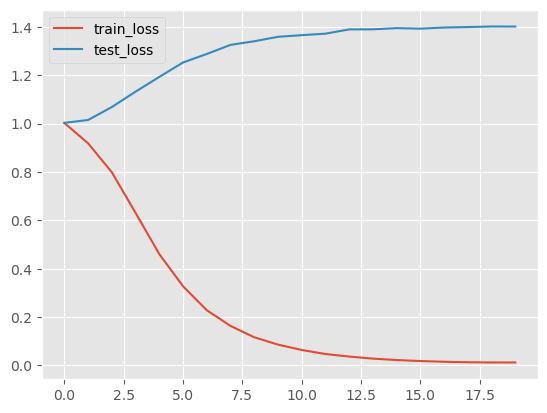

In [17]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [18]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [19]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,nn
y_true,1.000000,0.028724,0.030631,0.030675,0.994456
y_optimal,0.028724,1.000000,0.942811,0.936421,0.029486
lasso,0.030631,0.942811,1.000000,0.998581,0.031351
lr,0.030675,0.936421,0.998581,1.000000,0.031375
nn,0.994456,0.029486,0.031351,0.031375,1.000000


In [20]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,nn
y_true,1.000000,0.035473,0.033716,0.033939,0.004408
y_optimal,0.035473,1.000000,0.941967,0.935535,0.008899
lasso,0.033716,0.941967,1.000000,0.998582,0.013320
lr,0.033939,0.935535,0.998582,1.000000,0.013055
nn,0.004408,0.008899,0.013320,0.013055,1.000000


### LSTM model with 10 timestamps

In [21]:
train, test = utils.np_to_torch(X, y, n_rolling=10)

In [22]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [23]:
m = LSTMModel(n_ts=100, n_f=10, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [24]:
model_lstm.fit(train, test=test, epochs=10)

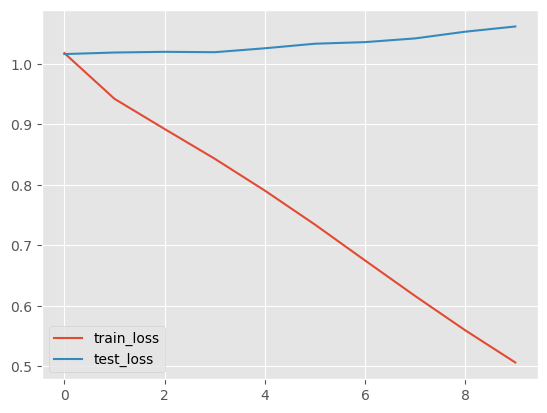

In [25]:
pd.concat([pd.Series(model_lstm.train_loss).rename('train_loss'), pd.Series(model_lstm.test_loss).rename('test_loss')], axis=1).plot();

In [26]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [27]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,lstm
y_true,1.000000,0.028724,0.030631,0.030675,0.779066
y_optimal,0.028724,1.000000,0.942811,0.936421,0.022161
lasso,0.030631,0.942811,1.000000,0.998581,0.024070
lr,0.030675,0.936421,0.998581,1.000000,0.024195
lstm,0.779066,0.022161,0.024070,0.024195,1.000000


In [28]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,lstm
y_true,1.000000,0.035473,0.033716,0.033939,0.009888
y_optimal,0.035473,1.000000,0.941967,0.935535,0.002838
lasso,0.033716,0.941967,1.000000,0.998582,0.002594
lr,0.033939,0.935535,0.998582,1.000000,0.002390
lstm,0.009888,0.002838,0.002594,0.002390,1.000000


### Transformer

In [29]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        encoded = self.encoder(x, src_key_padding_mask=mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [30]:
m = TransformerEncoderModel(100, 10, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [31]:
model_torch.fit(train, test=test, epochs=10)

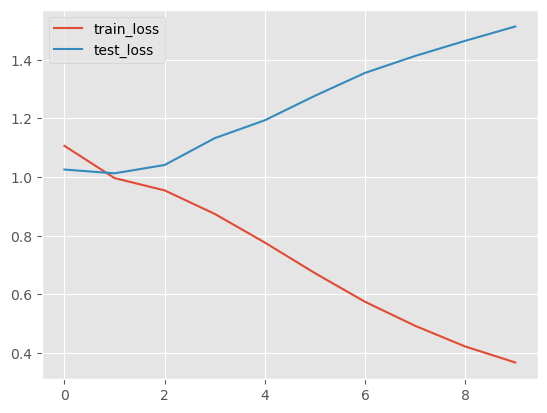

In [32]:
pd.concat([pd.Series(model_torch.train_loss).rename('train_loss'), pd.Series(model_torch.test_loss).rename('test_loss')], axis=1).plot();

In [33]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [34]:
comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,lstm,transformer
y_true,1.000000,0.028724,0.030631,0.030675,0.779066,0.845340
y_optimal,0.028724,1.000000,0.942811,0.936421,0.022161,0.030302
lasso,0.030631,0.942811,1.000000,0.998581,0.024070,0.032257
lr,0.030675,0.936421,0.998581,1.000000,0.024195,0.032374
lstm,0.779066,0.022161,0.024070,0.024195,1.000000,0.731426
transformer,0.845340,0.030302,0.032257,0.032374,0.731426,1.000000


In [35]:
comp.correl(test, z.y_pred_optimal[test.dataset.indices].flatten())

,y_true,y_optimal,lasso,lr,lstm,transformer
y_true,1.000000,0.035473,0.033716,0.033939,0.009888,-0.004937
y_optimal,0.035473,1.000000,0.941967,0.935535,0.002838,0.002194
lasso,0.033716,0.941967,1.000000,0.998582,0.002594,0.006735
lr,0.033939,0.935535,0.998582,1.000000,0.002390,0.006487
lstm,0.009888,0.002838,0.002594,0.002390,1.000000,0.195634
transformer,-0.004937,0.002194,0.006735,0.006487,0.195634,1.000000
